<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Chapter_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercises

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# 1. Using the code presented in Section 8.6:

## (a) Generate a dataset (X, y).


In [0]:
def getTestData(n_features=40,n_informative=10,n_redundant=10,n_samples=10000):
  # generate a random dataset for a classification problem
  from sklearn.datasets import make_classification
  trnsX,cont = make_classification(n_samples=n_samples,n_features=n_features,n_informative=n_informative,n_redundant=n_redundant,random_state=0,shuffle=False)
  df0 = pd.DatetimeIndex(periods=n_samples,freq=pd.tseries.offsets.BDay(), end=pd.datetime.today())
  trnsX,cont = pd.DataFrame(trnsX,index=df0), pd.Series(cont,index=df0).to_frame('bin')
  df0 = ['I_'+str(i) for i in range(n_informative)]+ ['R_'+str(i) for i in range(n_redundant)]
  df0+=['N_'+str(i) for i in range(n_features-len(df0))]
  trnsX.columns=df0
  cont['w']=1./cont.shape[0]
  cont['t1']=pd.Series(cont.index,index=cont.index)
  return trnsX,cont

In [163]:
trnsX, cont = getTestData(n_features=20,n_informative=5,n_redundant=5, n_samples=10000)
trnsX.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """


,I_0,I_1,I_2,I_3,I_4,R_0,R_1,R_2,R_3,R_4,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9
1981-08-19 11:10:02.855059,2.105359,2.861661,0.104159,0.686149,1.369429,0.598433,-2.128938,-4.712652,-1.440282,1.734748,-0.951867,0.350871,1.205282,0.518828,-0.126228,0.247306,-1.100988,-1.274187,-1.646382,0.148002
1981-08-20 11:10:02.855059,-0.330754,1.464379,-1.405119,0.396713,-1.722305,2.457629,1.360210,0.598880,-2.769403,2.148379,0.149130,-0.344994,-0.270242,-1.335891,-2.517104,-0.320609,-2.229938,-1.727211,1.524020,-0.171415
1981-08-21 11:10:02.855059,-0.461334,-0.160432,-2.169501,-0.137535,0.398229,0.807388,-0.032925,1.056388,-1.110272,-0.690573,1.385891,-0.994307,-1.020541,-0.671245,-0.013901,0.489610,1.761593,-0.371046,-0.939324,1.923307
1981-08-24 11:10:02.855059,-1.573667,3.110105,0.073939,1.232501,1.069429,2.660115,-0.758505,-1.797288,-0.598249,0.575557,1.374754,0.257797,0.108781,1.233139,0.484138,0.376817,0.491534,1.152249,-1.200973,0.363082
1981-08-25 11:10:02.855059,0.528677,1.538982,-1.603758,2.056413,0.777722,1.574457,-0.717575,-2.730023,-1.430891,0.096802,0.582142,1.279587,-1.104004,-1.288717,0.263587,0.125378,-1.919282,0.146416,-0.973685,1.649327


In [164]:
y=cont.bin
y

1981-08-19 11:10:02.855059    0
1981-08-20 11:10:02.855059    0
1981-08-21 11:10:02.855059    0
1981-08-24 11:10:02.855059    0
1981-08-25 11:10:02.855059    0
                             ..
2019-12-11 11:10:02.855059    1
2019-12-12 11:10:02.855059    1
2019-12-13 11:10:02.855059    1
2019-12-16 11:10:02.855059    1
2019-12-17 11:10:02.855059    1
Freq: B, Name: bin, Length: 10000, dtype: int64

In [165]:
y.value_counts()

1    5003
0    4997
Name: bin, dtype: int64

## (b) Apply a PCA transformation on $X$, which we denote $\dot{X}$.

In [0]:
from sklearn.decomposition import PCA

In [0]:
n=5
pca = PCA(n)
pca.fit(trnsX)
pcaX = pca.transform(trnsX)

In [168]:
pca.explained_variance_ratio_

array([0.27884877, 0.22660774, 0.13345306, 0.05864858, 0.0292165 ])

In [169]:
pcaX.shape

(10000, 5)

In [170]:
X = pd.DataFrame(index=trnsX.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=trnsX.index,name=i)
  X = X.join(a)
X

,0,1,2,3,4
1981-08-19 11:10:02.855059,-0.079478,6.987463,2.303134,0.284018,0.041992
1981-08-20 11:10:02.855059,-4.125725,0.696678,-0.653375,-0.033049,-0.512002
1981-08-21 11:10:02.855059,-0.143899,-0.960887,1.175653,0.844542,-1.798651
1981-08-24 11:10:02.855059,-1.599016,2.375769,3.393312,-1.555787,0.596834
1981-08-25 11:10:02.855059,-0.807683,3.098131,2.382476,1.715768,1.147588
...,...,...,...,...,...
2019-12-11 11:10:02.855059,-0.362427,-1.943164,-2.898029,2.299986,-0.269398
2019-12-12 11:10:02.855059,2.591074,-4.866338,0.950890,1.299394,0.321017
2019-12-13 11:10:02.855059,-0.735571,-4.388725,0.149137,-2.626403,-1.793254
2019-12-16 11:10:02.855059,-1.409797,-3.666857,-1.278288,-0.918072,0.151399


## (c) Compute MDI, MDA, and SFI feature importance on$(\dot{X}, y)$, where the base estimator is RF.

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
pip install -q mlfinlab

In [0]:
from mlfinlab import feature_importance

In [0]:
clf = RandomForestClassifier(n_estimators=100,max_features=1 ,criterion='entropy',class_weight='balanced_subsample',oob_score=True)
fit = clf.fit(X,y)

In [0]:
mdi = feature_importance.feature_importance_mean_decrease_impurity(clf=fit, feature_names = X.columns.to_list())

In [176]:
mdi.sort_values('mean', ascending=False)

,mean,std
2,0.421439,0.002705
0,0.207297,0.002034
3,0.142356,0.001886
1,0.116367,0.001556
4,0.112542,0.001182


In [0]:
from mlfinlab import cross_validation
cv_gen = cross_validation.PurgedKFold(5, cont['t1'], 0.01)

In [0]:
mda =feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=X,y=y,cv_gen=cv_gen, sample_weight=cont['w'])

In [182]:
mda.sort_values('mean',ascending=False)

,mean,std
2,0.553241,0.075444
0,0.342088,0.080315
3,0.246367,0.074087
4,0.091245,0.023775
1,0.026036,0.024903


In [0]:
sfi = feature_importance.feature_importance_sfi(clf=clf,X=X,y=y,cv_gen=cv_gen,sample_weight=cont['w'])

In [184]:
sfi.sort_values('mean',ascending=False)

,mean,std
4,-3.35337,0.404321
2,-3.56621,1.12803
1,-3.86668,0.449911
3,-3.97325,0.728429
0,-4.16636,1.01013


## (d) Do the three methods agree on what features are important? Why?

SFI의 importance는 혼자 조금 다르다.

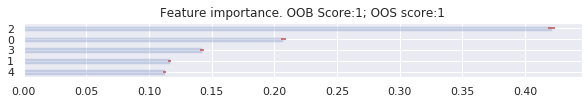

In [185]:
feature_importance.plot_feature_importance(imp=mdi,oob_score=1,oos_score=1)

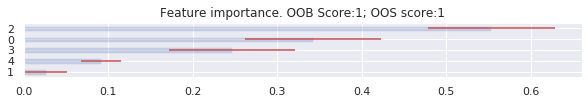

In [186]:
feature_importance.plot_feature_importance(imp=mda,oob_score=1,oos_score=1)

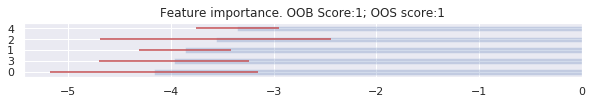

In [187]:
feature_importance.plot_feature_importance(imp=sfi,oob_score=1,oos_score=1)

# 2. From exercise 1, generate a new dataset ($\ddot{X} , y)$, where $\ddot{X}$ is a feature union of $X$ and ̇$\dot{X}$

In [191]:
X2 = trnsX.join(X)
X2.head()

,I_0,I_1,I_2,I_3,I_4,R_0,R_1,R_2,R_3,R_4,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,N_9,0,1,2,3,4
1981-08-19 11:10:02.855059,2.105359,2.861661,0.104159,0.686149,1.369429,0.598433,-2.128938,-4.712652,-1.440282,1.734748,-0.951867,0.350871,1.205282,0.518828,-0.126228,0.247306,-1.100988,-1.274187,-1.646382,0.148002,-0.079478,6.987463,2.303134,0.284018,0.041992
1981-08-20 11:10:02.855059,-0.330754,1.464379,-1.405119,0.396713,-1.722305,2.457629,1.360210,0.598880,-2.769403,2.148379,0.149130,-0.344994,-0.270242,-1.335891,-2.517104,-0.320609,-2.229938,-1.727211,1.524020,-0.171415,-4.125725,0.696678,-0.653375,-0.033049,-0.512002
1981-08-21 11:10:02.855059,-0.461334,-0.160432,-2.169501,-0.137535,0.398229,0.807388,-0.032925,1.056388,-1.110272,-0.690573,1.385891,-0.994307,-1.020541,-0.671245,-0.013901,0.489610,1.761593,-0.371046,-0.939324,1.923307,-0.143899,-0.960887,1.175653,0.844542,-1.798651
1981-08-24 11:10:02.855059,-1.573667,3.110105,0.073939,1.232501,1.069429,2.660115,-0.758505,-1.797288,-0.598249,0.575557,1.374754,0.257797,0.108781,1.233139,0.484138,0.376817,0.491534,1.152249,-1.200973,0.363082,-1.599016,2.375769,3.393312,-1.555787,0.596834
1981-08-25 11:10:02.855059,0.528677,1.538982,-1.603758,2.056413,0.777722,1.574457,-0.717575,-2.730023,-1.430891,0.096802,0.582142,1.279587,-1.104004,-1.288717,0.263587,0.125378,-1.919282,0.146416,-0.973685,1.649327,-0.807683,3.098131,2.382476,1.715768,1.147588


## (a) Compute MDI, MDA, and SFI feature importance on (Ẍ , y), where the base estimator is RF.

In [0]:
fit2 = clf.fit(X2,y)

In [0]:
mdi2 = feature_importance.feature_importance_mean_decrease_impurity(clf=fit2, feature_names = X2.columns.to_list())

In [216]:
mdi2.sort_values('mean',ascending=False).head(8)

,mean,std
2,0.110418,0.008164
R_0,0.089293,0.006263
I_1,0.087870,0.006481
I_4,0.066689,0.003593
0,0.054217,0.003204
I_2,0.053678,0.002719
R_1,0.053399,0.003367
I_0,0.049011,0.002186


In [0]:
mda2 =feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=X2,y=y,cv_gen=cv_gen, sample_weight=cont['w'])

In [217]:
mda2.sort_values('mean',ascending=False).head(8)

,mean,std
R_0,0.076616,0.024418
2,0.071454,0.049959
I_1,0.059825,0.033644
3,0.051881,0.016332
I_2,0.049351,0.017837
I_4,0.047708,0.030153
0,0.045410,0.022027
I_0,0.042317,0.023517


In [0]:
sfi2 = feature_importance.feature_importance_sfi(clf=clf,X=X2,y=y,cv_gen=cv_gen,sample_weight=cont['w'])

In [220]:
sfi2.sort_values('mean',ascending=True).head(8)

,mean,std
0,-4.29815,1.01713
R_1,-4.15423,0.404699
I_0,-4.13288,1.15339
R_0,-4.10421,0.671435
R_2,-4.0861,0.462301
I_4,-4.08406,0.541414
R_3,-3.98385,0.824386
I_2,-3.93145,1.24959


##(b) Do the three methods agree on the important features? Why?

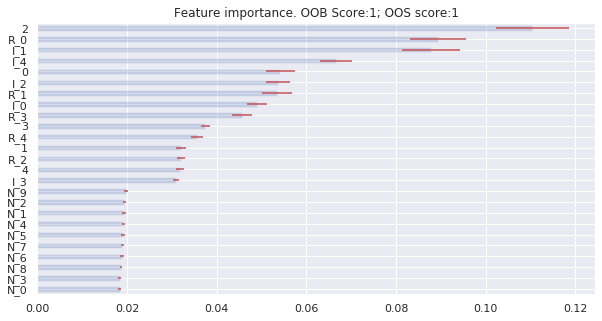

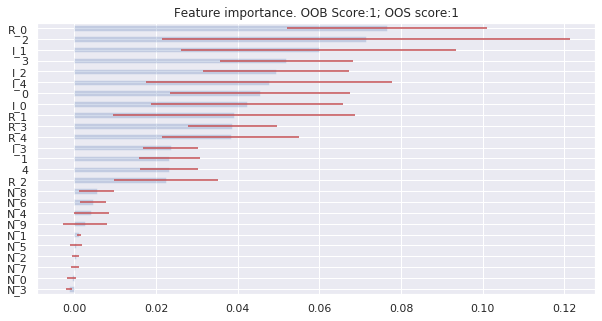

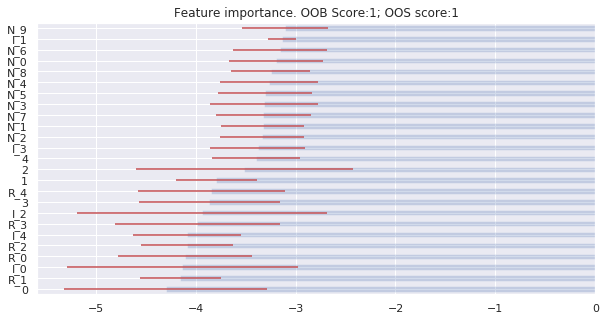

In [222]:
feature_importance.plot_feature_importance(imp=mdi2,oob_score=1,oos_score=1)
feature_importance.plot_feature_importance(imp=mda2,oob_score=1,oos_score=1)
feature_importance.plot_feature_importance(imp=sfi2,oob_score=1,oos_score=1)

SFI가 뭔가 잘못됐다. 반대로인가.

# 3. Take the results from exercise 2:
(a) Drop the most important features according to each method, resulting in a
features matrix ⃛X.
(b) Compute MDI, MDA, and SFI feature importance on (⃛X, y), where the base
estimator is RF.
(c) Do you appreciate significant changes in the rankings of important features,
relative to the results from exercise 2?

sfi는 잠시 안하겠다.

In [0]:
# 3개 빼보자.
drop = [2,'R_0','I_1']
X3 = X2.drop(drop,axis=1)

In [0]:
fit3 = clf.fit(X3,y)

In [0]:
mdi3 = feature_importance.feature_importance_mean_decrease_impurity(clf=fit3, feature_names = X3.columns.to_list())

In [212]:
mdi3.sort_values('mean',ascending=False).head(5)

,mean,std
I_4,0.093477,0.003825
0,0.081622,0.003016
R_1,0.076300,0.002895
I_0,0.075042,0.002628
I_2,0.074523,0.002975


In [0]:
mda3 = feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=X3,y=y,cv_gen=cv_gen, sample_weight=cont['w'])

In [215]:
mda3.sort_values('mean',ascending=False).head(5)

,mean,std
I_0,0.082449,0.032835
0,0.080901,0.025261
I_4,0.078295,0.038576
I_2,0.065433,0.026185
R_3,0.055288,0.017246


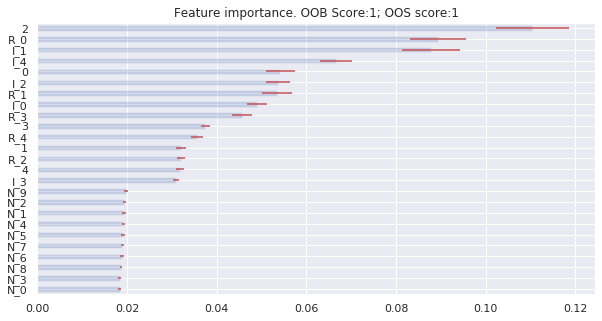

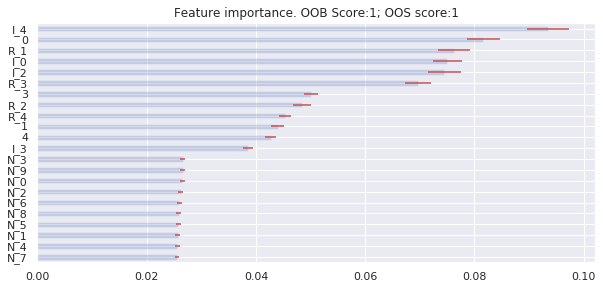

In [221]:
feature_importance.plot_feature_importance(imp=mdi2,oob_score=1,oos_score=1)
feature_importance.plot_feature_importance(imp=mdi3,oob_score=1,oos_score=1)

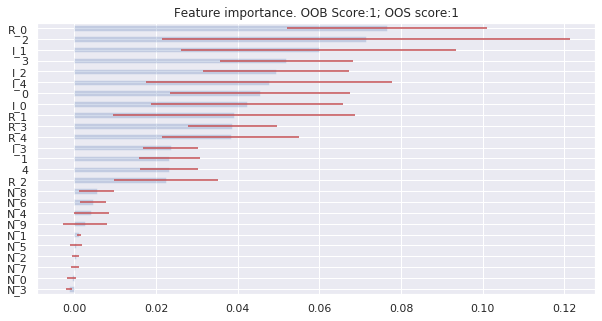

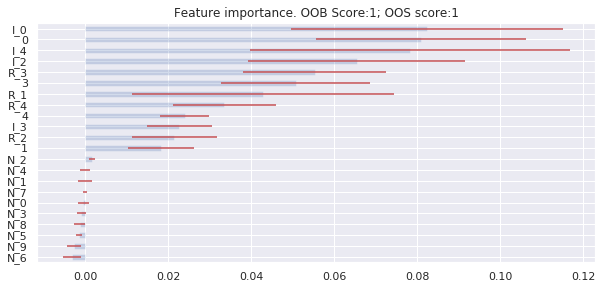

In [223]:
feature_importance.plot_feature_importance(imp=mda2,oob_score=1,oos_score=1)
feature_importance.plot_feature_importance(imp=mda3,oob_score=1,oos_score=1)

순위가 비슷한거같으나 다르긴하다.

# 4.Using the code presented in Section 8.6:

(a) Generate a dataset (X, y) of 1E6 observations, where 5 features are informative,
5 are redundant and 10 are noise.
(b) Split (X, y) into 10 datasets {(Xi, yi)}i=1,…,10, each of 1E5 observations.
(c) Compute the parallelized feature importance (Section 8.5), on each of the 10
datasets, {(Xi, yi)}i=1,…,10.
(d) Compute the stacked feature importance on the combined dataset (X, y).

In [227]:
trnsx2, y2 = getTestData(15,5,5,1000000) 

OverflowError: ignored

In [231]:
trnsx2, cont2 = getTestData(15,5,5,10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  """


In [0]:
y2 = cont2.bin
c2 = cont2

반복문쓰는거 잘 좀 알고싶다.

In [0]:
xa = trnsx2.iloc[0:2000]
xb = trnsx2.iloc[2000:4000]
xc = trnsx2.iloc[4000:6000]
xd = trnsx2.iloc[6000:8000]
xe = trnsx2.iloc[8000:10000]

ca = c2.iloc[0:2000]
cb = c2.iloc[2000:4000]
cc = c2.iloc[4000:6000]
cd = c2.iloc[6000:8000]
ce = c2.iloc[8000:10000]

ya = y2.iloc[0:2000]
yb = y2.iloc[2000:4000]
yc = y2.iloc[4000:6000]
yd = y2.iloc[6000:8000]
ye = y2.iloc[8000:10000]

In [241]:
cv_gena = cross_validation.PurgedKFold(3, ca['t1'], 0.01)
cv_genb = cross_validation.PurgedKFold(3, cb['t1'], 0.01)
cv_genc = cross_validation.PurgedKFold(3, cc['t1'], 0.01)
cv_gend = cross_validation.PurgedKFold(3, cd['t1'], 0.01)
cv_gene = cross_validation.PurgedKFold(3, ce['t1'], 0.01)


mdaa = feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=xa,y=ya,cv_gen=cv_gena, sample_weight=ca['w'])
mdab = feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=xb,y=yb,cv_gen=cv_genb, sample_weight=cb['w'])
mdac = feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=xc,y=yc,cv_gen=cv_genc, sample_weight=cc['w'])
mdad = feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=xd,y=yd,cv_gen=cv_gend, sample_weight=cd['w'])
mdae = feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=xe,y=ye,cv_gen=cv_gene, sample_weight=ce['w'])

print(mdaa.sort_values('mean',ascending=False).head())
print(mdab.sort_values('mean',ascending=False).head())
print(mdac.sort_values('mean',ascending=False).head())
print(mdad.sort_values('mean',ascending=False).head())
print(mdae.sort_values('mean',ascending=False).head())

         mean       std
I_1  0.050726  0.039985
I_4  0.050608  0.042746
I_0  0.036173  0.026800
I_2  0.029134  0.025646
I_3  0.027742  0.023558
         mean       std
I_4  0.286360  0.168057
I_1  0.208924  0.132225
R_0  0.198498  0.107133
R_1  0.193157  0.104119
R_4  0.160806  0.094777
         mean       std
I_4  0.063419  0.030933
I_1  0.055401  0.083299
R_3  0.049312  0.036539
I_2  0.042037  0.094535
R_0  0.036678  0.093618
         mean       std
I_2  0.107099  0.053764
I_3  0.054742  0.019247
I_0  0.022906  0.018156
R_2  0.018924  0.012256
R_4  0.005360  0.046685
         mean       std
I_4  0.090705  0.155269
I_3  0.008340  0.003794
N_3  0.001184  0.001020
N_1 -0.046717  0.045153
N_4 -0.118183  0.120620


In [0]:
따로해서합친거 = (mdaa['mean']+
mdab['mean']+
mdac['mean']+
mdad['mean']+
mdae['mean'])

In [249]:
따로해서합친거.to_frame().sort_values('mean',ascending=False)

,mean
I_4,0.473738
I_3,0.215172
N_1,0.074096
I_2,-0.001060
N_3,-0.005419
I_0,-0.007445
R_2,-0.125504
N_2,-0.151261
I_1,-0.276663
R_0,-0.444877


In [250]:
cv_gen2 = cross_validation.PurgedKFold(3, cont2['t1'], 0.01)
합쳐서한거 = feature_importance.feature_importance_mean_decrease_accuracy(clf=clf, X=trnsx2,y=y2,cv_gen=cv_gen2, sample_weight=cont2['w'])
합쳐서한거.sort_values('mean',ascending=False)

,mean,std
R_0,0.087175,0.078179
I_2,0.058215,0.037020
I_1,0.046753,0.056338
N_4,0.016077,0.006397
N_1,0.015364,0.007402
I_0,0.002690,0.079281
N_3,0.000991,0.012477
N_0,-0.001794,0.002800
N_2,-0.002218,0.002262
R_3,-0.003272,0.056308


딱히 우열이 가려지진않는다..

#5. Repeat all MDI calculations from exercises 1–4, but this time allow for masking effects. That means, do not set max_features=int(1) in Snippet 8.2. How do results differ as a consequence of this change? Why?

         mean       std
2    0.110418  0.008164
R_0  0.089293  0.006263
I_1  0.087870  0.006481
I_4  0.066689  0.003593
0    0.054217  0.003204
I_2  0.053678  0.002719
R_1  0.053399  0.003367
I_0  0.049011  0.002186


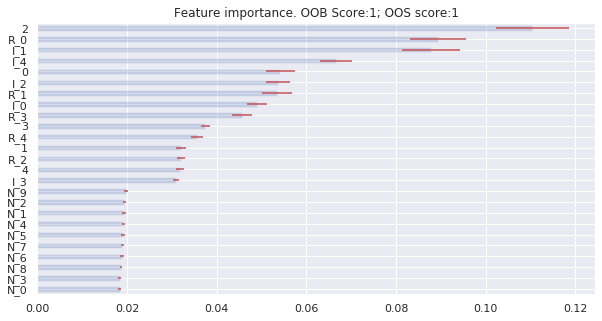

In [255]:
# 2번 것으로 하겠다.
#우선 max_features=1로 했을때,
print(mdi2.sort_values('mean',ascending=False).head(8))
feature_importance.plot_feature_importance(imp=mdi2,oob_score=1,oos_score=1)

In [0]:
#max_features = 자동으로 놓겠다.

clf2 = RandomForestClassifier(n_estimators=100,criterion='entropy',class_weight='balanced_subsample',oob_score=True)
fitb = clf2.fit(X2,y)

         mean       std
2    0.185775  0.010740
R_0  0.123753  0.007559
I_1  0.091851  0.007771
I_2  0.072063  0.003094
I_4  0.064726  0.004702
3    0.056325  0.001353
0    0.047745  0.004094
R_3  0.045579  0.002898


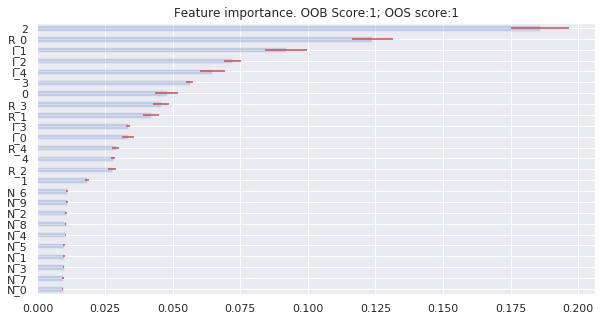

In [260]:
mdib = feature_importance.feature_importance_mean_decrease_impurity(clf=fitb, feature_names = X2.columns.to_list())
print(mdib.sort_values('mean',ascending=False).head(8))
feature_importance.plot_feature_importance(imp=mdib,oob_score=1,oos_score=1)

순위가 조금 다르고, max_features=1일때 importance가 더 고르다.

Masking effects take place when some features are systematically ignored
by tree-based classifiers in favor of others. In order to avoid them, set
max_features=int(1)when using sklearn’s RF class. In this way, only one
random feature is considered per level.

(a) Every feature is given a chance (at some random levels of some random
trees) to reduce impurity.

(b) Make sure that features with zero importance are not averaged, since the
only reason for a 0 is that the feature was not randomly chosen. Replace
those values with np.nan.